# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

**Import Necessary Libraries**

In [ ]:
import os
from PIL import Image
import numpy as np
import zipfile
from collections import Counter
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split

#Further analysis using classification_report and confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

Load the dataset.

In [ ]:

zippath = "data.zip"
extract_path = "/content/" #Changed to lower case c

# Check if the zip file exists
if os.path.exists(zippath):
    # Unzip the dataset
    try: #Added a try-except block to handle BadZipFile exceptions
        with zipfile.ZipFile(zippath, 'r') as zip_ref:
            if os.path.exists(os.path.join(extract_path, "data")):
                # Check if the directory already exists
                print(f"Directory {extract_path} already exists. Please remove it before extracting.")
                exit(1)
            else:
                zip_ref.extractall(extract_path)
        print(f"Dataset successfully extracted to {extract_path}")
    except zipfile.BadZipFile:
        print(f"Error: {zippath} is not a valid zip file or is corrupted.")
else:
    print(f"Zip file not found at {zippath}. Please check the path.")

Dataset successfully extracted to /content/


## **2. Data Preparation** <font color=red> [25 marks] </font><br>

### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# prompt: Create a function to load the images with labels folders

def load_images_with_labels(root_dir):
    images = []
    labels = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(label_dir, filename)
                    try:
                        img = Image.open(img_path)
                        images.append(np.array(img))
                        labels.append(label)
                    except (IOError, OSError) as e:
                        print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Path to the main folder containing subfolders
data_path = os.path.join(extract_path, 'data')

In [ ]:
# Get the images and their labels
images, labels = load_images_with_labels(data_path)
print(f"Loaded {len(images)} images with labels.")

Loaded 7625 images with labels.


In [ ]:
# Check the number of images and labels
len(images), len(labels)

(7625, 7625)

In [ ]:
categories = np.unique(labels)
print(f"Categories: {categories}")

Categories: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


In [ ]:


# Count the occurrences of each category
category_counts = Counter(labels)

# Print the number of images in each category
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")


Category 'Food_Waste': 1000 images
Category 'Other': 1010 images
Category 'Plastic': 2295 images
Category 'Metal': 1000 images
Category 'Paper': 1030 images
Category 'Cardboard': 540 images
Category 'Glass': 750 images


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

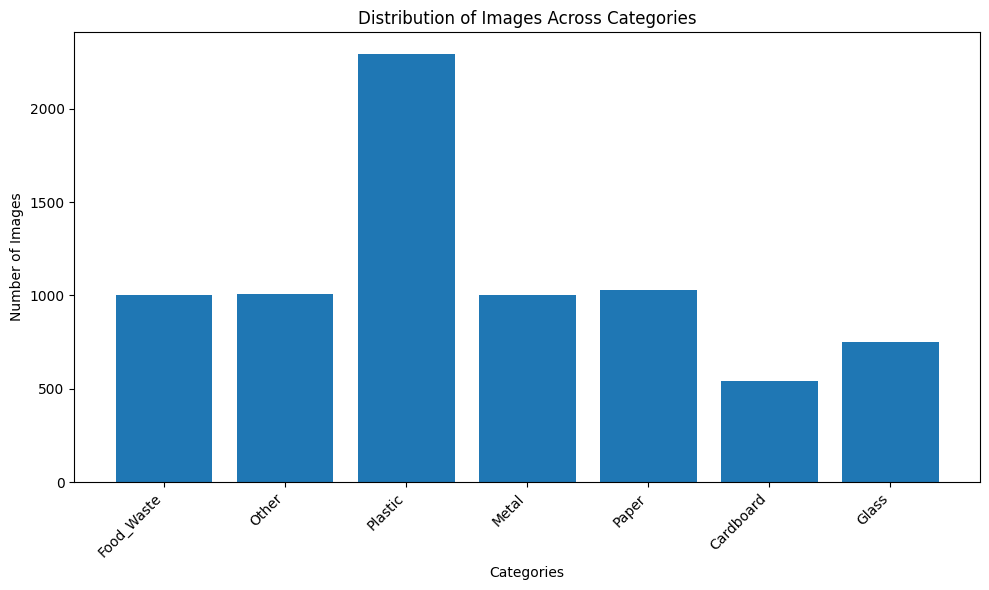

In [ ]:
# Visualise Data Distribution
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Distribution of Images Across Categories")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

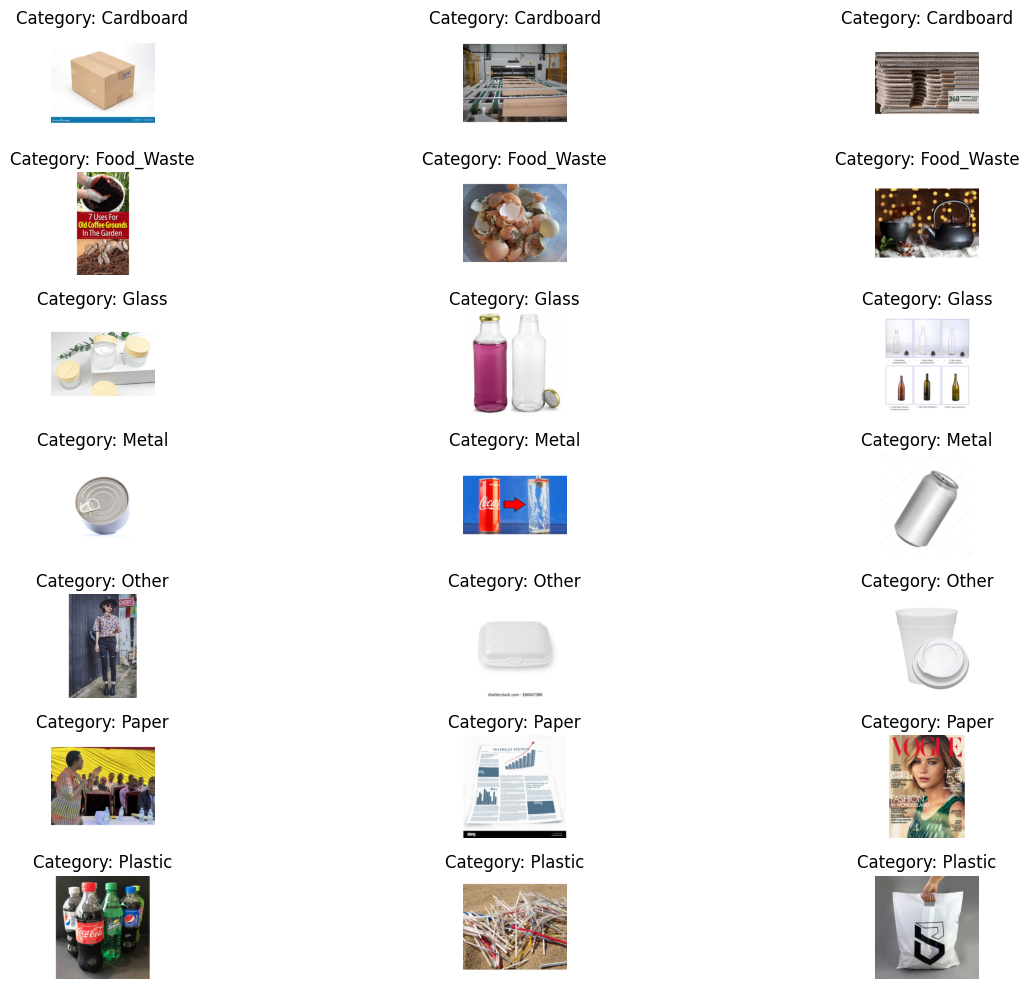

In [ ]:
# prompt: # Visualise Sample Images (across different labels)

# Assuming 'images' and 'labels' are already loaded as in the previous code

num_samples_per_category = 3  # Number of samples to display per category

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    category_indices = [j for j, label in enumerate(labels) if label == category]

    # Select random samples within the category
    selected_indices = random.sample(category_indices, min(num_samples_per_category, len(category_indices)))

    for j, index in enumerate(selected_indices):
        plt.subplot(len(categories), num_samples_per_category, i * num_samples_per_category + j + 1)
        plt.imshow(images[index])
        plt.title(f"Category: {category}")
        plt.axis('off')

plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# prompt: # Find the smallest and largest image dimensions from the data set

def find_min_max_dimensions(image_array):
    """
    Finds the smallest and largest image dimensions in a NumPy array of images.

    Args:
        image_array: A NumPy array where each element is an image represented as a NumPy array.

    Returns:
        A tuple containing two tuples: (min_dimensions, max_dimensions).
        Each inner tuple represents (width, height).
    """

    if not isinstance(image_array, np.ndarray) or image_array.size == 0:
        return None, None

    min_width = float('inf')
    min_height = float('inf')
    max_width = float('-inf')
    max_height = float('-inf')

    for image in image_array:
        if isinstance(image, np.ndarray) and len(image.shape) >= 2:
            height, width = image.shape[:2]  # Handle grayscale and color images
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            max_width = max(max_width, width)
            max_height = max(max_height, height)

    if min_width == float('inf'): #Check if any valid images were found
        return (0,0), (0,0)

    return (min_width, min_height), (max_width, max_height)


min_dims, max_dims = find_min_max_dimensions(images)
print(f"Minimum dimensions: {min_dims}")
print(f"Maximum dimensions: {max_dims}")


Minimum dimensions: (256, 256)
Maximum dimensions: (256, 256)


In [ ]:
# prompt: # Resize the image dimensions

def resize_images(image_array, target_size):
    resized_images = []
    for image in image_array:
        img = Image.fromarray(image)
        img = img.resize(target_size)
        resized_images.append(np.array(img))
    return np.array(resized_images)

# Example usage: Resize all images to 128x128
target_size = (128, 128)
resized_images = resize_images(images, target_size)

# Verify the new shape of the resized images
print("Original Image Shape:", images[0].shape)  # Print shape of the first original image
print("Resized Image Shape:", resized_images[0].shape) # Print shape of the first resized image

min_dims, max_dims = find_min_max_dimensions(resized_images)
print(f"Minimum dimensions (resized): {min_dims}")
print(f"Maximum dimensions (resized): {max_dims}")


Original Image Shape: (256, 256, 3)
Resized Image Shape: (128, 128, 3)
Minimum dimensions (resized): (128, 128)
Maximum dimensions (resized): (128, 128)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# prompt: # Encode the labels suitably

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the mapping between original labels and encoded labels
for i, category in enumerate(label_encoder.classes_):
    print(f"Original Label: {category}, Encoded Label: {i}")

# Now you can use encoded_labels in your model training


Original Label: Cardboard, Encoded Label: 0
Original Label: Food_Waste, Encoded Label: 1
Original Label: Glass, Encoded Label: 2
Original Label: Metal, Encoded Label: 3
Original Label: Other, Encoded Label: 4
Original Label: Paper, Encoded Label: 5
Original Label: Plastic, Encoded Label: 6


In [ ]:
# prompt: # Convert to one-hot encoding

# ... (Your existing code)

# Convert encoded labels to one-hot encoding
num_classes = len(np.unique(encoded_labels))
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

# Now you have one-hot_labels which you can use for your model.
one_hot_labels


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# prompt: # Assign specified parts of the dataset to train and validation sets

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(resized_images, one_hot_labels, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (6100, 128, 128, 3)
y_train shape: (6100, 7)
X_val shape: (1525, 128, 128, 3)
y_val shape: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

In [ ]:
# prompt: Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model

# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add dropout for regularization

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,945,351 (49.38 MB)

 Trainable params: 12,943,879 (49.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2801 - loss: 2.5007

191/191 ━━━━━━━━━━━━━━━━━━━━ 71s 353ms/step - accuracy: 0.2803 - loss: 2.4990 - val_accuracy: 0.2925 - val_loss: 4.4644
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 362ms/step - accuracy: 0.3964 - loss: 1.8053 - val_accuracy: 0.2216 - val_loss: 3.0527
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4676 - loss: 1.5580

191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - accuracy: 0.4677 - loss: 1.5578 - val_accuracy: 0.3325 - val_loss: 3.0986
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5046 - loss: 1.3945

191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 354ms/step - accuracy: 0.5047 - loss: 1.3944 - val_accuracy: 0.3338 - val_loss: 2.4886
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5714 - loss: 1.2000

191/191 ━━━━━━━━━━━━━━━━━━━━ 70s 365ms/step - accuracy: 0.5714 - loss: 1.2000 - val_accuracy: 0.3777 - val_loss: 1.7362
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6084 - loss: 1.1129

191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - accuracy: 0.6084 - loss: 1.1130 - val_accuracy: 0.4374 - val_loss: 1.6339
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6664 - loss: 0.9461

191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 357ms/step - accuracy: 0.6664 - loss: 0.9461 - val_accuracy: 0.5679 - val_loss: 1.2180
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 350ms/step - accuracy: 0.7171 - loss: 0.8024 - val_accuracy: 0.5311 - val_loss: 1.3578
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7571 - loss: 0.6985

191/191 ━━━━━━━━━━━━━━━━━━━━ 73s 381ms/step - accuracy: 0.7570 - loss: 0.6985 - val_accuracy: 0.5685 - val_loss: 1.2546
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8047 - loss: 0.5811

191/191 ━━━━━━━━━━━━━━━━━━━━ 105s 547ms/step - accuracy: 0.8046 - loss: 0.5811 - val_accuracy: 0.6079 - val_loss: 1.2510
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 360ms/step - accuracy: 0.8480 - loss: 0.4383 - val_accuracy: 0.4944 - val_loss: 2.0781
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 362ms/step - accuracy: 0.8678 - loss: 0.4028 - val_accuracy: 0.5475 - val_loss: 1.3975
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5486 - loss: 1.2627
Validation Loss: 1.2180
Validation Accuracy: 0.5679
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
              precision    recall  f1-score   support

           0       0.89      0.59      0.71        93
           1       0.59      0.67      0.63       205
           2       0.43      0.53      0.47       158
           3       0.46      0.69      0.55       192
           4       0.63      0.36      0.46       234
           5       0.75      0.35      0.47       197
           6       0.58      0.68      0.63       446

    accuracy   

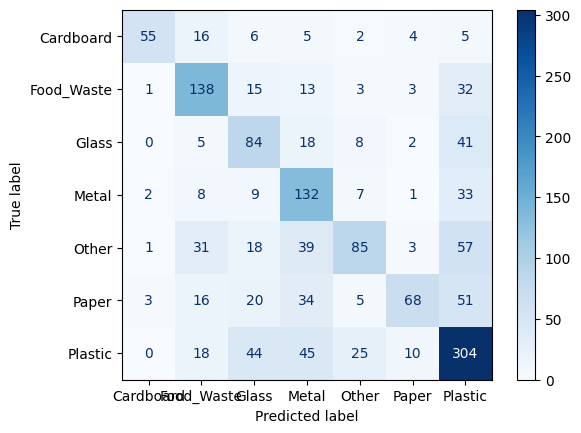

Accuracy: 0.5678688524590164
Precision: 0.5997077245063113
Recall: 0.5678688524590164
F1-score: 0.5620815535368053


In [ ]:
# prompt: train the model with metrics and callbacks as needed.

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


#Further analysis using classification_report and confusion_matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted') #Use weighted for multiclass
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5486 - loss: 1.2627
Test Loss: 1.2180
Test Accuracy: 0.5679
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
              precision    recall  f1-score   support

   Cardboard       0.89      0.59      0.71        93
  Food_Waste       0.59      0.67      0.63       205
       Glass       0.43      0.53      0.47       158
       Metal       0.46      0.69      0.55       192
       Other       0.63      0.36      0.46       234
       Paper       0.75      0.35      0.47       197
     Plastic       0.58      0.68      0.63       446

    accuracy                           0.57      1525
   macro avg       0.62      0.55      0.56      1525
weighted avg       0.60      0.57      0.56      1525



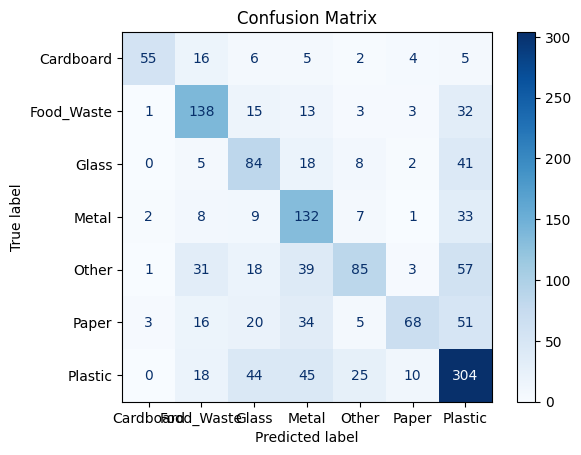

Accuracy: 0.5678688524590164
Precision: 0.6185969396685026
Recall: 0.5533934326840291
F1-score: 0.5612159575428965


In [ ]:
# prompt: Evaluate the model on test dataset. Derive appropriate metrics.

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

#Further analysis using classification_report and confusion_matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)) #Use target_names for class labels

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix") #Added title to the plot
plt.show()

#Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro') #Use macro for multiclass
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


In [ ]:
# prompt: create another model

# Define the second model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the second model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the second model
model2.summary()

# Train the second model
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,568,903 (112.80 MB)

 Trainable params: 29,568,903 (112.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 430ms/step - accuracy: 0.3014 - loss: 2.5103 - val_accuracy: 0.3593 - val_loss: 1.6843
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 424ms/step - accuracy: 0.4657 - loss: 1.4626 - val_accuracy: 0.4846 - val_loss: 1.4279
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.6558 - loss: 0.9919 - val_accuracy: 0.5587 - val_loss: 1.3459
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.8064 - loss: 0.5887 - val_accuracy: 0.5351 - val_loss: 1.5682
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.9000 - loss: 0.3160 - val_accuracy: 0.5738 - val_loss: 1.7755
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.9451 - loss: 0.1976 - val_accuracy: 0.5895 - val_loss: 2.1774
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 426ms/step - accuracy: 0.9737 - loss: 0.1201 - val_accuracy: 0.5941 - val_loss: 2.2428
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 424ms/step - accuracy: 0.9799 - loss: 0

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5815 - loss: 2.6854
Second Model - Validation Loss: 2.6560
Second Model - Validation Accuracy: 0.5849
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
              precision    recall  f1-score   support

   Cardboard       0.78      0.66      0.71        93
  Food_Waste       0.75      0.55      0.63       205
       Glass       0.72      0.39      0.50       158
       Metal       0.46      0.68      0.55       192
       Other       0.67      0.38      0.48       234
       Paper       0.48      0.51      0.49       197
     Plastic       0.58      0.76      0.66       446

    accuracy                           0.58      1525
   macro avg       0.63      0.56      0.58      1525
weighted avg       0.61      0.58      0.58      1525



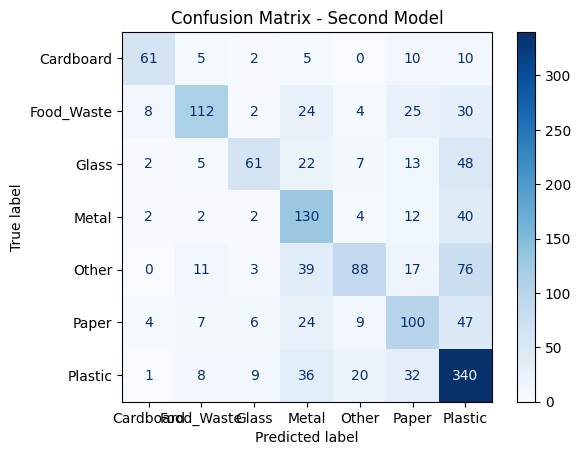

Second Model - Accuracy: 0.5849180327868853
Second Model - Precision: 0.6330117709009174
Second Model - Recall: 0.5587755932058639
Second Model - F1-score: 0.5752234482832584


In [ ]:
# prompt: evaluate the model

# Evaluate the second model
loss, accuracy = model2.evaluate(X_val, y_val)
print(f"Second Model - Validation Loss: {loss:.4f}")
print(f"Second Model - Validation Accuracy: {accuracy:.4f}")

#Further analysis using classification_report and confusion_matrix for the second model
y_pred = model2.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Second Model") #Added title to the plot
plt.show()

#Calculate additional metrics for the second model
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Second Model - Accuracy: {accuracy}")
print(f"Second Model - Precision: {precision}")
print(f"Second Model - Recall: {recall}")
print(f"Second Model - F1-score: {f1}")


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.3133 - loss: 1.9591 - val_accuracy: 0.3751 - val_loss: 1.6361
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.4250 - loss: 1.5199 - val_accuracy: 0.4498 - val_loss: 1.3966
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.4991 - loss: 1.3385 - val_accuracy: 0.5010 - val_loss: 1.3341
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.6192 - loss: 1.0585 - val_accuracy: 0.5482 - val_loss: 1.3443
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.7355 - loss: 0.7430 - val_accuracy: 0.5698 - val_loss: 1.3623
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.8338 - loss: 0.4826 - val_accuracy: 0.5751 - val_loss: 1.5811
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.9025 - loss: 0.2914 - val_accuracy: 0.6085 - val_loss: 1.7253
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9530 - loss: 0

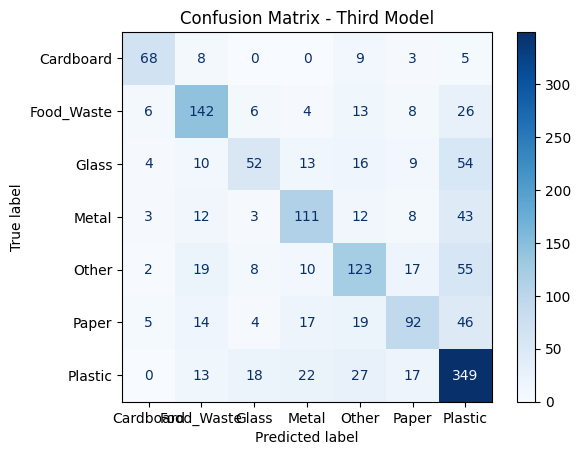

Third Model - Accuracy: 0.6144262295081967
Third Model - Precision: 0.6265004709150528
Third Model - Recall: 0.5866088513034736
Third Model - F1-score: 0.5987108886210702


In [ ]:
# prompt: build another model

# ... (Your existing code)

# Define the third model
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the third model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the third model
model3.summary()

# Train the third model
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the third model
loss, accuracy = model3.evaluate(X_val, y_val)
print(f"Third Model - Validation Loss: {loss:.4f}")
print(f"Third Model - Validation Accuracy: {accuracy:.4f}")

#Further analysis using classification_report and confusion_matrix for the third model
y_pred = model3.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Third Model") #Added title to the plot
plt.show()

#Calculate additional metrics for the third model
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Third Model - Accuracy: {accuracy}")
print(f"Third Model - Precision: {precision}")
print(f"Third Model - Recall: {recall}")
print(f"Third Model - F1-score: {f1}")


#### **4.1 Create a Data Augmentation Pipeline**

## **4. Data Augmentation** <font color=red> [optional] </font><br>

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

## Findings about the data

#### Dataset Composition:
 - The dataset consits of images from 7 different categories, namely `Cardboard`, `Food_Waste`, `Glass`, `Metal`, `Paper`,   `Plastic` and `Other`.
 - Each class is represented by a folder containing images of Objects belonging to each category.

### Class Distribution:
 - The dataset has an imbalanced distribution of images across the classes as observed from the bar plot of class distribution.
 - `Plastic` has siginificantly more images(2295) than other categories, `Cardboard` has very low images(540).
 - This might affect model performance.

### Image Characterristics:
 - Images in data set are prest in `.png` format.
 - Resize operation was performed to standardize all images to 128x128 pixels size.

### Label Encoding:
 - Lables were extracted from folder names and encoded into numerical values.
 - One-hot encoding was applied to prepare the labels for model traning.

### Data Splitting:
 - Dataset was split into training & validation sets using 80:20, ensuring the stratification to maintain class distribution in both sets.

### Potential Issues:
 - Dataset contains class imbalance, which may require techniques like data augumentation or class weighting to improve model performance.
 - Some images have overlapping feature between classes, making classification more chaleenging.




**Conclusion:**

-  Model 3 demonstrates a moderate level of performance in image classification with an accuracy of 0.6144. However, there's significant room for improvement in precision, recall, and overall accuracy.
- Data augmentation, hyperparameter tuning, and addressing potential class imbalance are essential steps to enhance the model's performance.
- Architectural adjustments and further exploration of model variations could be considered to achieve better accuracy and more robust classification capabilities.

**Overall Assessment:**

- Model 3's architecture, featuring 3 convolutional layers, provides a foundation for image feature extraction, but may require further refinement for optimal performance.
- The training process with 20 epochs and a batch size of 32 allows the model to learn from the data, but further tuning could be explored.
- Model 3 presents a balance between complexity and performance, but the accuracy and other metrics indicate that there's potential for improvement.
- The relatively lower accuracy, precision, recall, and F1-score suggest that the model is prone to misclassifications and may require adjustments to enhance its discriminative capabilities.